# Transfer learning for Mixed Eye Fundus

## Libraries

In [1]:
import os
import csv
import PIL
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.10.1'

## Data exploration

In [3]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\2110191048\\Dataset\\dataset_mixed_splitted.csv'
headers = ['Image', 'Label']

In [4]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [5]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\2110191048\\Dataset\\Dataset (Splitted)\\'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [6]:
# Load and preview the CSV dataset file

dataset_mixed_df = pd.read_csv('D:\\2110191048\\Dataset\\dataset_mixed_splitted.csv')
dataset_mixed_df

,Image,Label
0,mixed - 10 - cataract (1003).jpg,Cataract
1,mixed - 10 - cataract (1038).jpg,Cataract
2,mixed - 10 - cataract (105).jpg,Cataract
3,mixed - 10 - cataract (11).jpg,Cataract
4,mixed - 10 - cataract (112).jpg,Cataract
...,...,...
4307,mixed - 10 - normal (962).jpg,Normal
4308,mixed - 10 - normal (967).jpg,Normal
4309,mixed - 10 - normal (977).jpg,Normal
4310,mixed - 10 - normal (981).jpg,Normal


In [7]:
# The dataset inside the CSV file has around 9534 list of images

print('Mixed dataset shape:', dataset_mixed_df.shape)
print('Mixed dataset axes:', dataset_mixed_df.axes)

Mixed dataset shape: (4312, 2)
Mixed dataset axes: [RangeIndex(start=0, stop=4312, step=1), Index(['Image', 'Label'], dtype='object')]


In [8]:
# Print the classes used for the classification

print('The labels are:', dataset_mixed_df['Label'].unique())

The labels are: ['Cataract' 'DR' 'Glaucoma' 'Normal']


In [9]:
# Count each class images

print(dataset_mixed_df.groupby('Label')['Image'].nunique())

print('\nType:', type(dataset_mixed_df.groupby('Label')['Image'].nunique()))

label_count = dataset_mixed_df.groupby('Label')['Image'].nunique()
label_count = label_count.to_numpy()
print('\nLabel count:', label_count)

Label
Cataract    1038
DR          1098
Glaucoma    1105
Normal      1071
Name: Image, dtype: int64

Type: <class 'pandas.core.series.Series'>

Label count: [1038 1098 1105 1071]


In [10]:
print(dataset_mixed_df.iloc[[0]]['Image'])
print(dataset_mixed_df.iloc[[100]]['Image'])

0    mixed - 10 - cataract (1003).jpg
Name: Image, dtype: object
100    mixed - 10 - cataract (947).jpg
Name: Image, dtype: object


[Text(0, 0, '1038'),
 Text(0, 0, '1098'),
 Text(0, 0, '1105'),
 Text(0, 0, '1071')]

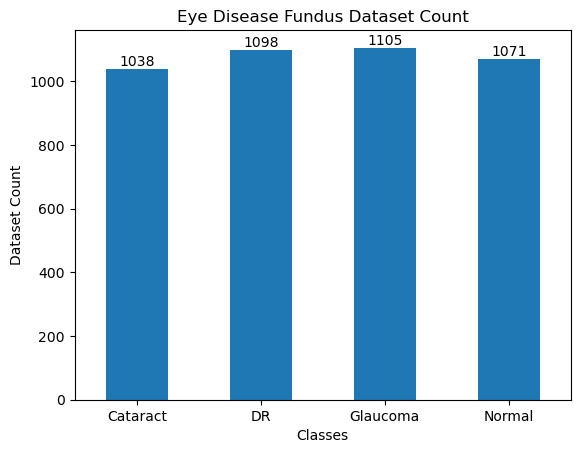

In [11]:
# Plotting the dataset count in each class

dataset_df_chart = dataset_mixed_df.groupby('Label')['Image'].nunique().plot(kind='bar', 
                                                                             title='Eye Disease Fundus Dataset Count',
                                                                             xlabel='Classes',
                                                                             ylabel='Dataset Count',
                                                                             rot=0)

dataset_df_chart.bar_label(dataset_df_chart.containers[0])

In [12]:
# Set the dataset base directory

os.chdir('D:\\2110191048\\Dataset\\Dataset (Splitted)')
dataset_dir = os.getcwd()
print('Dataset directory:', dataset_dir)

Dataset directory: D:\2110191048\Dataset\Dataset (Splitted)


In [13]:
# Set the train, val, and test dataset path

train_url = dataset_dir + '\\train'
val_url = dataset_dir + '\\val'
test_url = dataset_dir + '\\test'

train_dir = pathlib.Path(train_url)
val_dir = pathlib.Path(val_url)
test_dir = pathlib.Path(test_url)

print('train_url\t:', train_url)
print('val_url\t\t:', val_url)
print('test_url\t:', test_url)

print('\ntrain_dir\t:', train_dir)
print('val_dir\t\t:', val_dir)
print('test_dir\t:', test_dir)

train_url	: D:\2110191048\Dataset\Dataset (Splitted)\train
val_url		: D:\2110191048\Dataset\Dataset (Splitted)\val
test_url	: D:\2110191048\Dataset\Dataset (Splitted)\test

train_dir	: D:\2110191048\Dataset\Dataset (Splitted)\train
val_dir		: D:\2110191048\Dataset\Dataset (Splitted)\val
test_dir	: D:\2110191048\Dataset\Dataset (Splitted)\test


In [14]:
# Image count in each dataset

train_count = len(list(train_dir.glob('*/*')))
val_count = len(list(val_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print('Total training set images:\t', train_count)
print('Total validation set images\t:', val_count)
print('Total test set images\t\t:', test_count)

Total training set images:	 3448
Total validation set images	: 429
Total test set images		: 435


In [15]:
# Create dictionary of datagens and generators from each dataset

data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}

data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

### Find the classes distribution

Train information
---------------
Label names		: ['Cataract', 'DR', 'Glaucoma', 'Normal']
Label counts		: [830, 878, 884, 856]
Total image count	: 3448 

Val information
---------------
Label names		: ['Cataract', 'DR', 'Glaucoma', 'Normal']
Label counts		: [103, 109, 110, 107]
Total image count	: 429 

Test information
---------------
Label names		: ['Cataract', 'DR', 'Glaucoma', 'Normal']
Label counts		: [105, 111, 111, 108]
Total image count	: 435 



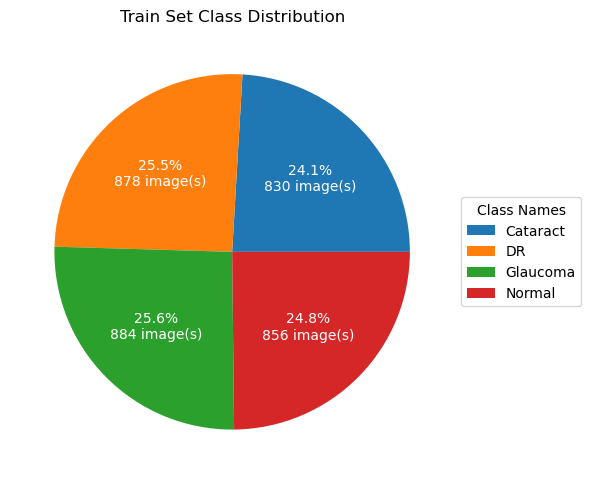

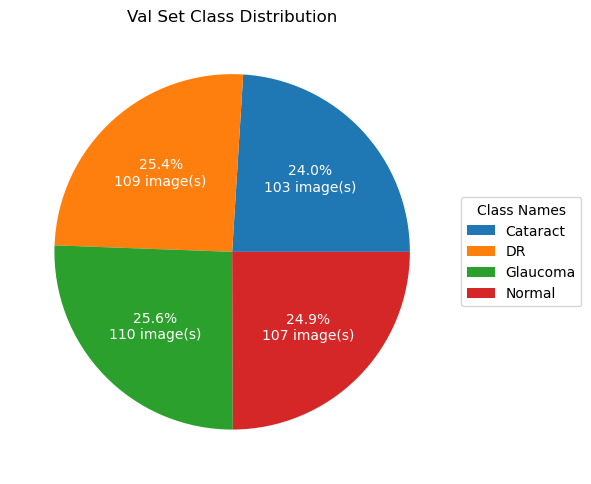

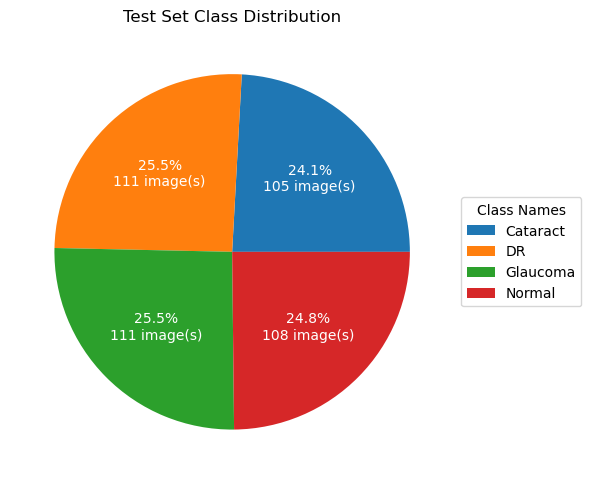

In [16]:
# Set and plot each dataset's classes distribution

for phase in ['train', 'val', 'test']:
    if phase == 'train':
        data_dir = train_dir
    elif phase == 'val':
        data_dir = val_dir
    elif phase == 'test':
        data_dir = test_dir

    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 

    image_files = [[
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ] for i in range(num_class)]

    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []

    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])

    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f'{phase.capitalize()} information')
    print('-'*15)
    print(f'Label names\t\t: {class_names}')
    print(f'Label counts\t\t: {num_each}')
    print(f'Total image count\t: {num_total}', '\n')

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n{absolute:d} image(s)"

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(num_each, 
                                        labels=class_names, 
                                        autopct=lambda pct: func(pct, num_each), 
                                        textprops=dict(color='w'))
    ax.legend(wedges, 
                class_names,
                title='Class Names',
                loc='center left',
                bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'{phase.capitalize()} Set Class Distribution')
    plt.tight_layout()

In [17]:
# Set some training hyperparameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('IMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32
IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


## Data loading & augmentation

In [18]:
# Create the datagen for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

from tensorflow.keras.applications.xception import preprocess_input # Adjust with the model we want to use

datagen = {
    'train': ImageDataGenerator(
        # rescale=1/255.0,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='constant',
        # shear_range=5.0,
        # zoom_range=[0.5, 1.0],
        # brightness_range=(0.5, 1.5),
        # width_shift_range=(0.0, 0.15),
        # height_shift_range=(0.0, 0.15),
        preprocessing_function=preprocess_input

    ),
    'val': ImageDataGenerator(
        # rescale=1/255.0,
        preprocessing_function=preprocess_input
    ),
    'test': ImageDataGenerator(
        # rescale=1/255.0,
        preprocessing_function=preprocess_input
    ),
}

In [19]:
# Create the image generator for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\mixed_test_images\\Cataract.jpg'
augmentation_dest_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\mixed_augmentations_examples'

data_sets = {
    'train': datagen['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,

        # Uncomment this beneath line if we want to preview and save some augmented images
        # save_to_dir=augmentation_dest_path,
        # save_prefix='aug',
        # save_format='png'
    ),
    'val': datagen['val'].flow_from_directory(
        val_dir, 
        shuffle=True, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,
    ),
    'test': datagen['test'].flow_from_directory(
        test_dir, 
        shuffle=False, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE
    )
}

Found 3448 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Found 435 images belonging to 4 classes.


In [20]:
# Uncomment this section if we want to preview and save some augmented images

# 
# test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\mixed_test_images\\Cataract.jpg'
# augmentation_dest_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\mixed_augmentations_examples'
# 
# i = 0
# 
# for batch in data_sets['train']:
#     i = i + 1
#     if i >= 30:
#         break

In [21]:
# Let's take a look at the dataset properties after being created with ImageDataGenerator 

for i, (images, labels) in enumerate(data_sets['train']):
    print('First batch labels:', labels)
    print('Labels shape:', labels.shape)
    print('Images shape:', images.shape)
    break

First batch labels: [3. 0. 0. 3. 2. 2. 0. 0. 0. 0. 3. 1. 2. 1. 3. 0. 1. 1. 3. 1. 2. 0. 2. 2.
 3. 0. 1. 1. 0. 0. 2. 3.]
Labels shape: (32,)
Images shape: (32, 100, 100, 3)


In [22]:
# Check if the image is rescaled or preprocessed

for k in range(len(images)):
    print(f'Max: {np.max(images[k])} | Min: {np.min(images[k])}')

Max: 0.9888330698013306 | Min: -1.0
Max: 0.9998210668563843 | Min: -1.0
Max: 0.9899493455886841 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9964476823806763 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.3008894920349121 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9133418798446655 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.8538167476654053 | Min: -1.0
Max: 0.9944448471069336 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9864629507064819 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9994446039199829 | Min: -1.0
Max: -0.3272346258163452 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9805655479431152 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9998645782470703 | Min: -1.0
Max: 0.8617342710494995 | Min: -1.0
Max: -0.40947264432907104 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.7542639970779419 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9579449892044067 | Min: -1.0


### Preview the image dataset

In [23]:
# Show the nine images and labels from the dataset

def show_images(GRID=[3,3], model=None, size=(8,8), data_type='train'):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    i = 1
    plt.figure(figsize=size)

    data = data_sets[data_type]

    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image.astype('uint8'))
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        
        if data_type == 'train':
            plt.suptitle('Preprocessed/Augmented Train Images')
        elif data_type == 'val':
            plt.suptitle('Preprocessed/Augmented Validation Images')
        elif data_type == 'test':
            plt.suptitle('Preprocessed/Augmented Test Images')

        plt.axis('on')
        i+=1
        
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

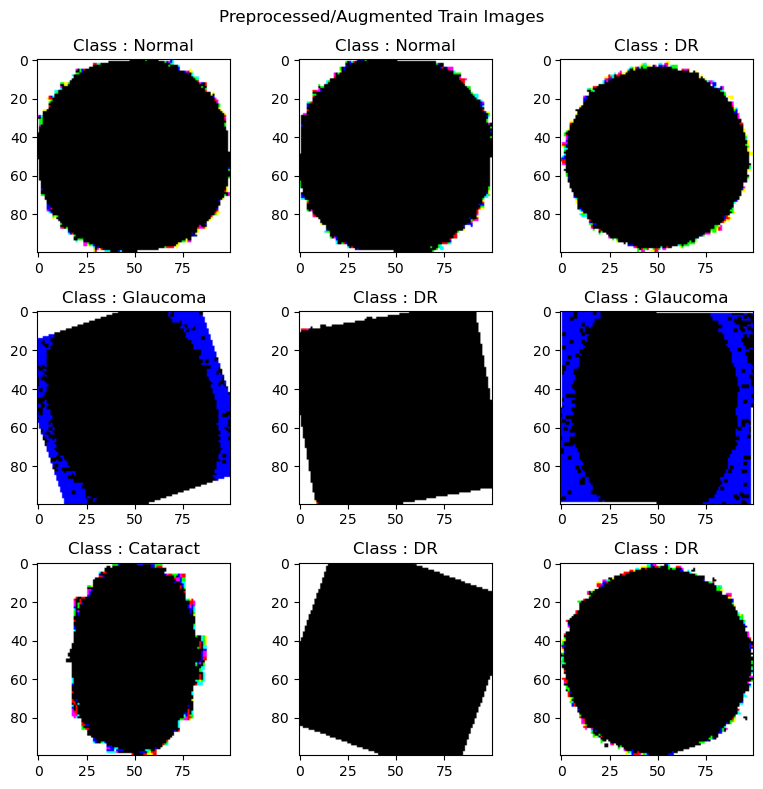

In [24]:
# Check and show images from training data generator

show_images(data_type='train')

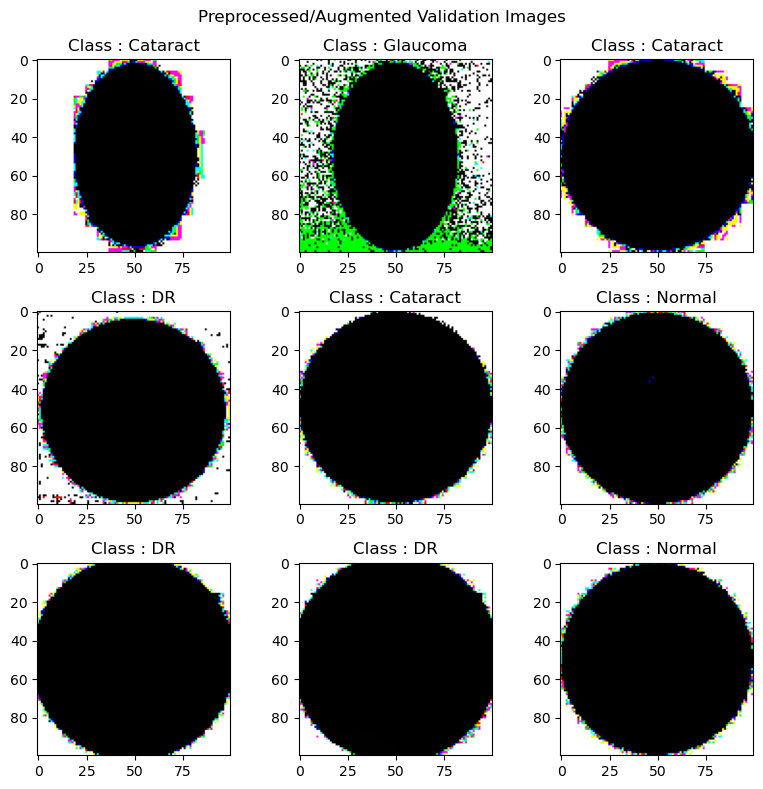

In [25]:
# Check and show images from validation data generator

show_images(data_type='val')

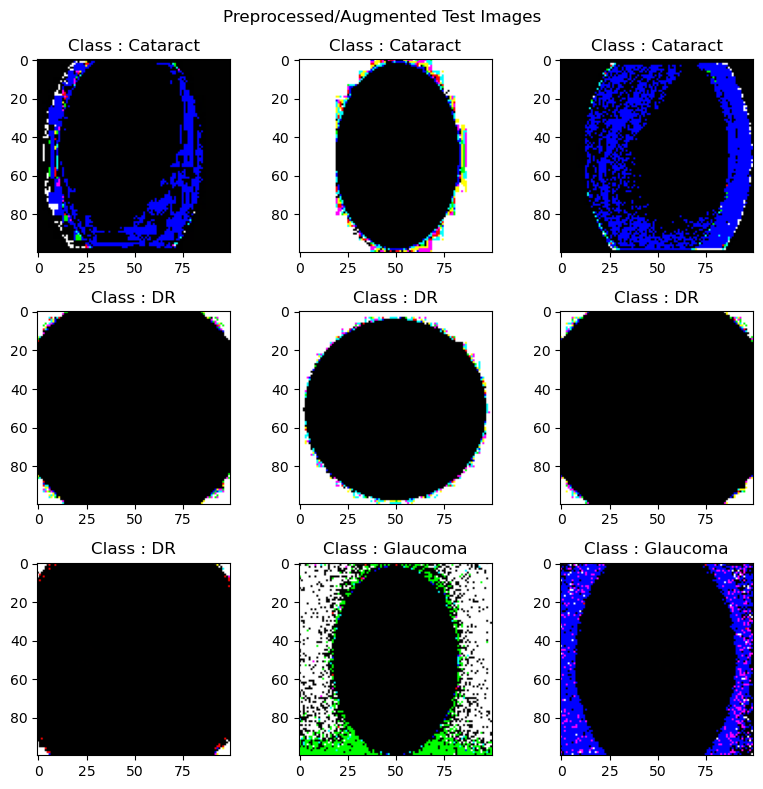

In [26]:
# Check and show images from test data generator

show_images(data_type='test')

## Create the base model

In [27]:
# Create the base model from the pre-trained model - Xception

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

## Feature extraction

In [28]:
# Showing all layers name in the base model

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

### Freeze the trainable layers

In [29]:
base_model.trainable = False

In [30]:
# Take a look at the base model architecture

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

### Add additional top layers

In [31]:
# Create the whole model with some additional top layers

model = tf.keras.Sequential()
model.add(base_model)

# from this layers to the top layer can be modified for further experiments
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [32]:
# Take a look at the new whole model architecture now
# Based on layers that we have added in the code above, we can observe from the model summary in 
# "trainable params" section that there are additional layers 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                        

### Compile the model

In [33]:
BASE_LR = 0.0001

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR), # Optimizers could be changed for further experiments
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy',
            #    tf.keras.metrics.BinaryAccuracy(),
            #    tf.keras.metrics.Precision(),
            #    tf.keras.metrics.Recall(),
            #    tf.keras.metrics.AUC(),
            #    tf.keras.metrics.TruePositives(),
            #    tf.keras.metrics.TrueNegatives(),
            #    tf.keras.metrics.FalsePositives(),
            #    tf.keras.metrics.FalseNegatives()
      ])

In [34]:
# Check again whether this model summary is different from before or not

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                        

In [35]:
len(model.trainable_variables)

8

In [36]:
# Try to evaluate the model using validation dataset before training process

loss0, accuracy0 = model.evaluate(data_sets['val'])

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

14/14 [==============================] - 24s 867ms/step - loss: 1.8768 - accuracy: 0.2657
Initial loss: 1.88
Initial accuracy: 0.27


### Define some model callbacks

In [37]:
# Define some callbacks for the model

trained_model_path = 'D:\\2110191048\\eye-disease-classification-app\\deep-learning-model\\trained_model\\'

# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    trained_model_path + 'xception_mixed_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # This could be changed in the future for further experiments
    verbose=1,
    restore_best_weights=True,
    min_delta=0.1 # This could be changed in the future for further experiments
)

# Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8,
    patience=3, 
    min_lr=1e-5, 
    verbose=1
)

# Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard('./tb_logs/run_logs')

### Train the whole model

In [38]:
INIT_EPOCH = 30 # This could be changed for further experiments

history = model.fit(data_sets['train'],
                    epochs=INIT_EPOCH,
                    validation_data=data_sets['val'],
                    callbacks=[model_checkpoint, tensorboard])

Epoch 1/30
108/108 [==============================] - ETA: 0s - loss: 0.8888 - accuracy: 0.6557
Epoch 1: val_loss improved from inf to 0.59554, saving model to D:\2110191048\eye-disease-classification-app\deep-learning-model\trained_model\xception_mixed_best_model.h5
108/108 [==============================] - 104s 922ms/step - loss: 0.8888 - accuracy: 0.6557 - val_loss: 0.5955 - val_accuracy: 0.8065
Epoch 2/30
108/108 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8161
Epoch 2: val_loss improved from 0.59554 to 0.47630, saving model to D:\2110191048\eye-disease-classification-app\deep-learning-model\trained_model\xception_mixed_best_model.h5
108/108 [==============================] - 95s 881ms/step - loss: 0.5155 - accuracy: 0.8161 - val_loss: 0.4763 - val_accuracy: 0.8228
Epoch 3/30
108/108 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8405
Epoch 3: val_loss improved from 0.47630 to 0.45563, saving model to D:\2110191048\eye-disease-c

### Learning curves

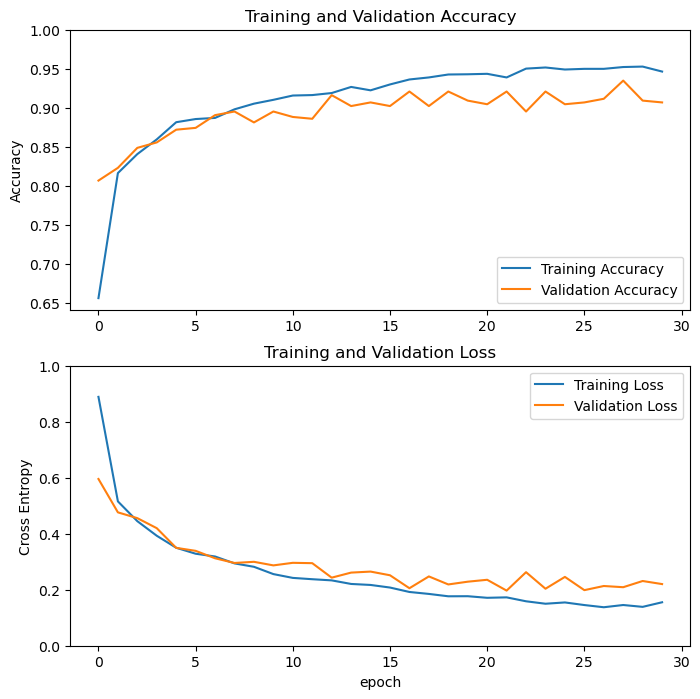

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

**Explanation of fine tuning**

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable. If we add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and our pre-trained model will forget what it has learned.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

In [40]:
# Un-freeze the base model

base_model.trainable = True

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100 # This could be changed for further experiments

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 132


### Compile the model

In [42]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR/10),
    metrics=['accuracy',
        # tf.keras.metrics.BinaryAccuracy(),
        # tf.keras.metrics.Precision(),
        # tf.keras.metrics.Recall(),
        # tf.keras.metrics.AUC(),
        # tf.keras.metrics.TruePositives(),
        # tf.keras.metrics.TrueNegatives(),
        # tf.keras.metrics.FalsePositives(),
        # tf.keras.metrics.FalseNegatives()
    ])

In [43]:
# Take a final look at the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                        

In [44]:
len(model.trainable_variables)

47

### Continue training the model

In [45]:
FINE_TUNE_EPOCHS = 10 # This could be changed for further experiments
total_epochs =  INIT_EPOCH + FINE_TUNE_EPOCHS

history_fine = model.fit(data_sets['train'],
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=data_sets['val'])

Epoch 30/40
108/108 [==============================] - 98s 852ms/step - loss: 1.0456 - accuracy: 0.5873 - val_loss: 0.7891 - val_accuracy: 0.7902
Epoch 31/40
108/108 [==============================] - 91s 839ms/step - loss: 0.5942 - accuracy: 0.8138 - val_loss: 0.6466 - val_accuracy: 0.8135
Epoch 32/40
108/108 [==============================] - 92s 849ms/step - loss: 0.4124 - accuracy: 0.8796 - val_loss: 0.3428 - val_accuracy: 0.8881
Epoch 33/40
108/108 [==============================] - 91s 836ms/step - loss: 0.3187 - accuracy: 0.9101 - val_loss: 0.2676 - val_accuracy: 0.9114
Epoch 34/40
108/108 [==============================] - 90s 834ms/step - loss: 0.2630 - accuracy: 0.9153 - val_loss: 0.2411 - val_accuracy: 0.9207
Epoch 35/40
108/108 [==============================] - 91s 840ms/step - loss: 0.2481 - accuracy: 0.9220 - val_loss: 0.2327 - val_accuracy: 0.9277
Epoch 36/40
108/108 [==============================] - 91s 843ms/step - loss: 0.2091 - accuracy: 0.9316 - val_loss: 0.2149 -

### Learning curves after fine-tuning

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

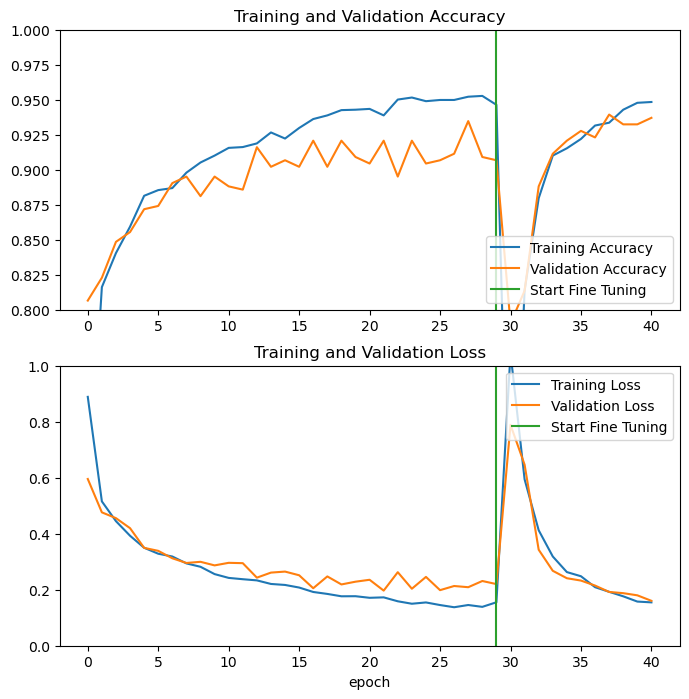

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation on test dataset

In [48]:
loss, accuracy = model.evaluate(data_sets['test'])

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2f}".format(accuracy))

14/14 [==============================] - 10s 745ms/step - loss: 0.2121 - accuracy: 0.9494
Test loss: 0.21
Test accuracy: 0.95


## Prediction on test dataset

In [49]:
# Retrieve a batch of images from the test set
# image_batch, label_batch = data_sets['train'].as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

prediction_results = model.predict(data_sets['test'])
print('prediction_results:', prediction_results)
print('prediction_results len:', len(prediction_results))

predicted_id = tf.math.argmax(prediction_results, axis=1)
print('predicted_id:', predicted_id)
print('predicted_id len:', len(predicted_id))

class_names = np.array(class_names)
print('class_names:', class_names)

predicted_label_batch = class_names[predicted_id]
print('predicted_label_batch:', predicted_label_batch)

predictions_df = pd.DataFrame(prediction_results)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   # plt.title(class_names[predictions[i]])
#   plt.title(predicted_label_batch[i])
#   plt.axis("off")

# predictions = model.predict(data_sets['test'])
# print('Number of predicted images:', len(predictions))
# print('Predictions:', predictions)
# print('Predictions shape:', predictions.shape)

# predictions_df = pd.DataFrame(predictions)

14/14 [==============================] - 10s 687ms/step
prediction_results: [[9.9347258e-01 3.1181512e-04 5.1140292e-03 1.1016187e-03]
 [9.5337063e-01 2.2341949e-03 4.3319695e-02 1.0755103e-03]
 [9.5522517e-01 3.9553557e-05 9.1879489e-03 3.5547394e-02]
 ...
 [3.4829453e-03 4.8110567e-02 5.6334483e-03 9.4277304e-01]
 [2.7105249e-05 2.3098388e-03 3.5825331e-04 9.9730480e-01]
 [1.5067706e-03 1.3089913e-03 2.3674772e-03 9.9481684e-01]]
prediction_results len: 435
predicted_id: tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 3 0 0 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 2 2 0 2
 2 2 3 3 1 0 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [50]:
data_sets['test'].classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [51]:
predictions_df

,0,1,2,3
0,0.993473,0.000312,0.005114,0.001102
1,0.953371,0.002234,0.043320,0.001076
2,0.955225,0.000040,0.009188,0.035547
3,0.985181,0.000170,0.000626,0.014023
4,0.952823,0.004464,0.003671,0.039042
...,...,...,...,...
430,0.005073,0.003032,0.028234,0.963662
431,0.002273,0.004105,0.000819,0.992803
432,0.003483,0.048111,0.005633,0.942773
433,0.000027,0.002310,0.000358,0.997305


In [52]:
# Converts each predicted value into labels

predictions_df['y_pred'] = predicted_id
predictions_df

,0,1,2,3,y_pred
0,0.993473,0.000312,0.005114,0.001102,0
1,0.953371,0.002234,0.043320,0.001076,0
2,0.955225,0.000040,0.009188,0.035547,0
3,0.985181,0.000170,0.000626,0.014023,0
4,0.952823,0.004464,0.003671,0.039042,0
...,...,...,...,...,...
430,0.005073,0.003032,0.028234,0.963662,3
431,0.002273,0.004105,0.000819,0.992803,3
432,0.003483,0.048111,0.005633,0.942773,3
433,0.000027,0.002310,0.000358,0.997305,3


In [53]:
# Add y_true into predictions_df

print(data_sets['test'].classes)
predictions_df['y_true'] = data_sets['test'].classes
predictions_df

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


,0,1,2,3,y_pred,y_true
0,0.993473,0.000312,0.005114,0.001102,0,0
1,0.953371,0.002234,0.043320,0.001076,0,0
2,0.955225,0.000040,0.009188,0.035547,0,0
3,0.985181,0.000170,0.000626,0.014023,0,0
4,0.952823,0.004464,0.003671,0.039042,0,0
...,...,...,...,...,...,...
430,0.005073,0.003032,0.028234,0.963662,3,3
431,0.002273,0.004105,0.000819,0.992803,3,3
432,0.003483,0.048111,0.005633,0.942773,3,3
433,0.000027,0.002310,0.000358,0.997305,3,3


In [54]:

predictions_df.columns = [class_names[0], class_names[1], class_names[2], class_names[3], 'y_pred', 'y_true']
predictions_df

,Cataract,DR,Glaucoma,Normal,y_pred,y_true
0,0.993473,0.000312,0.005114,0.001102,0,0
1,0.953371,0.002234,0.043320,0.001076,0,0
2,0.955225,0.000040,0.009188,0.035547,0,0
3,0.985181,0.000170,0.000626,0.014023,0,0
4,0.952823,0.004464,0.003671,0.039042,0,0
...,...,...,...,...,...,...
430,0.005073,0.003032,0.028234,0.963662,3,3
431,0.002273,0.004105,0.000819,0.992803,3,3
432,0.003483,0.048111,0.005633,0.942773,3,3
433,0.000027,0.002310,0.000358,0.997305,3,3


In [55]:
y_pred_in_numpy = np.array(predictions_df['y_pred'])
y_pred_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2,
       0, 2, 2, 2, 3, 3, 1, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [56]:
y_true_in_numpy = np.array(predictions_df['y_true'])
y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [57]:
 # Creating CSV file path and its headers

csv_file_path = 'D:\\2110191048\\Dataset\\test_dataset_mixed.csv'
headers = ['Image', 'Label']

In [58]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [59]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\2110191048\\Dataset\\Dataset (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [60]:
# Load and preview the CSV dataset file

test_mixed_df = pd.read_csv('D:\\2110191048\\Dataset\\test_dataset_mixed.csv')
test_mixed_df

,Image,Label
0,mixed - 10 - cataract (1003).jpg,Cataract
1,mixed - 10 - cataract (1038).jpg,Cataract
2,mixed - 10 - cataract (105).jpg,Cataract
3,mixed - 10 - cataract (11).jpg,Cataract
4,mixed - 10 - cataract (112).jpg,Cataract
...,...,...
430,mixed - 10 - normal (966).jpg,Normal
431,mixed - 10 - normal (968).jpg,Normal
432,mixed - 10 - normal (969).jpg,Normal
433,mixed - 10 - normal (980).jpg,Normal


Label
DR          111
Glaucoma    111
Normal      108
Cataract    105
Name: count, dtype: int64

Total predicted images: 435


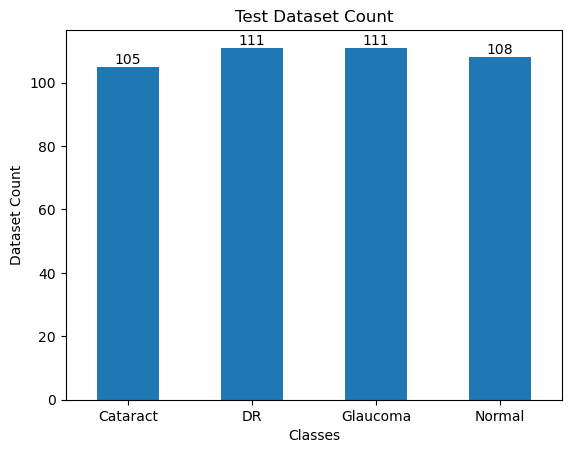

In [61]:
test_mixed_df['Label'].value_counts()
print(test_mixed_df['Label'].value_counts())

# View the above in a bar graph
test_df_chart = test_mixed_df.groupby('Label')['Image'].nunique().plot(kind='bar',
                                                          title='Test Dataset Count',
                                                          xlabel='Classes',
                                                          ylabel='Dataset Count',
                                                          rot=0)

test_df_chart.bar_label(test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", test_mixed_df.shape[0])

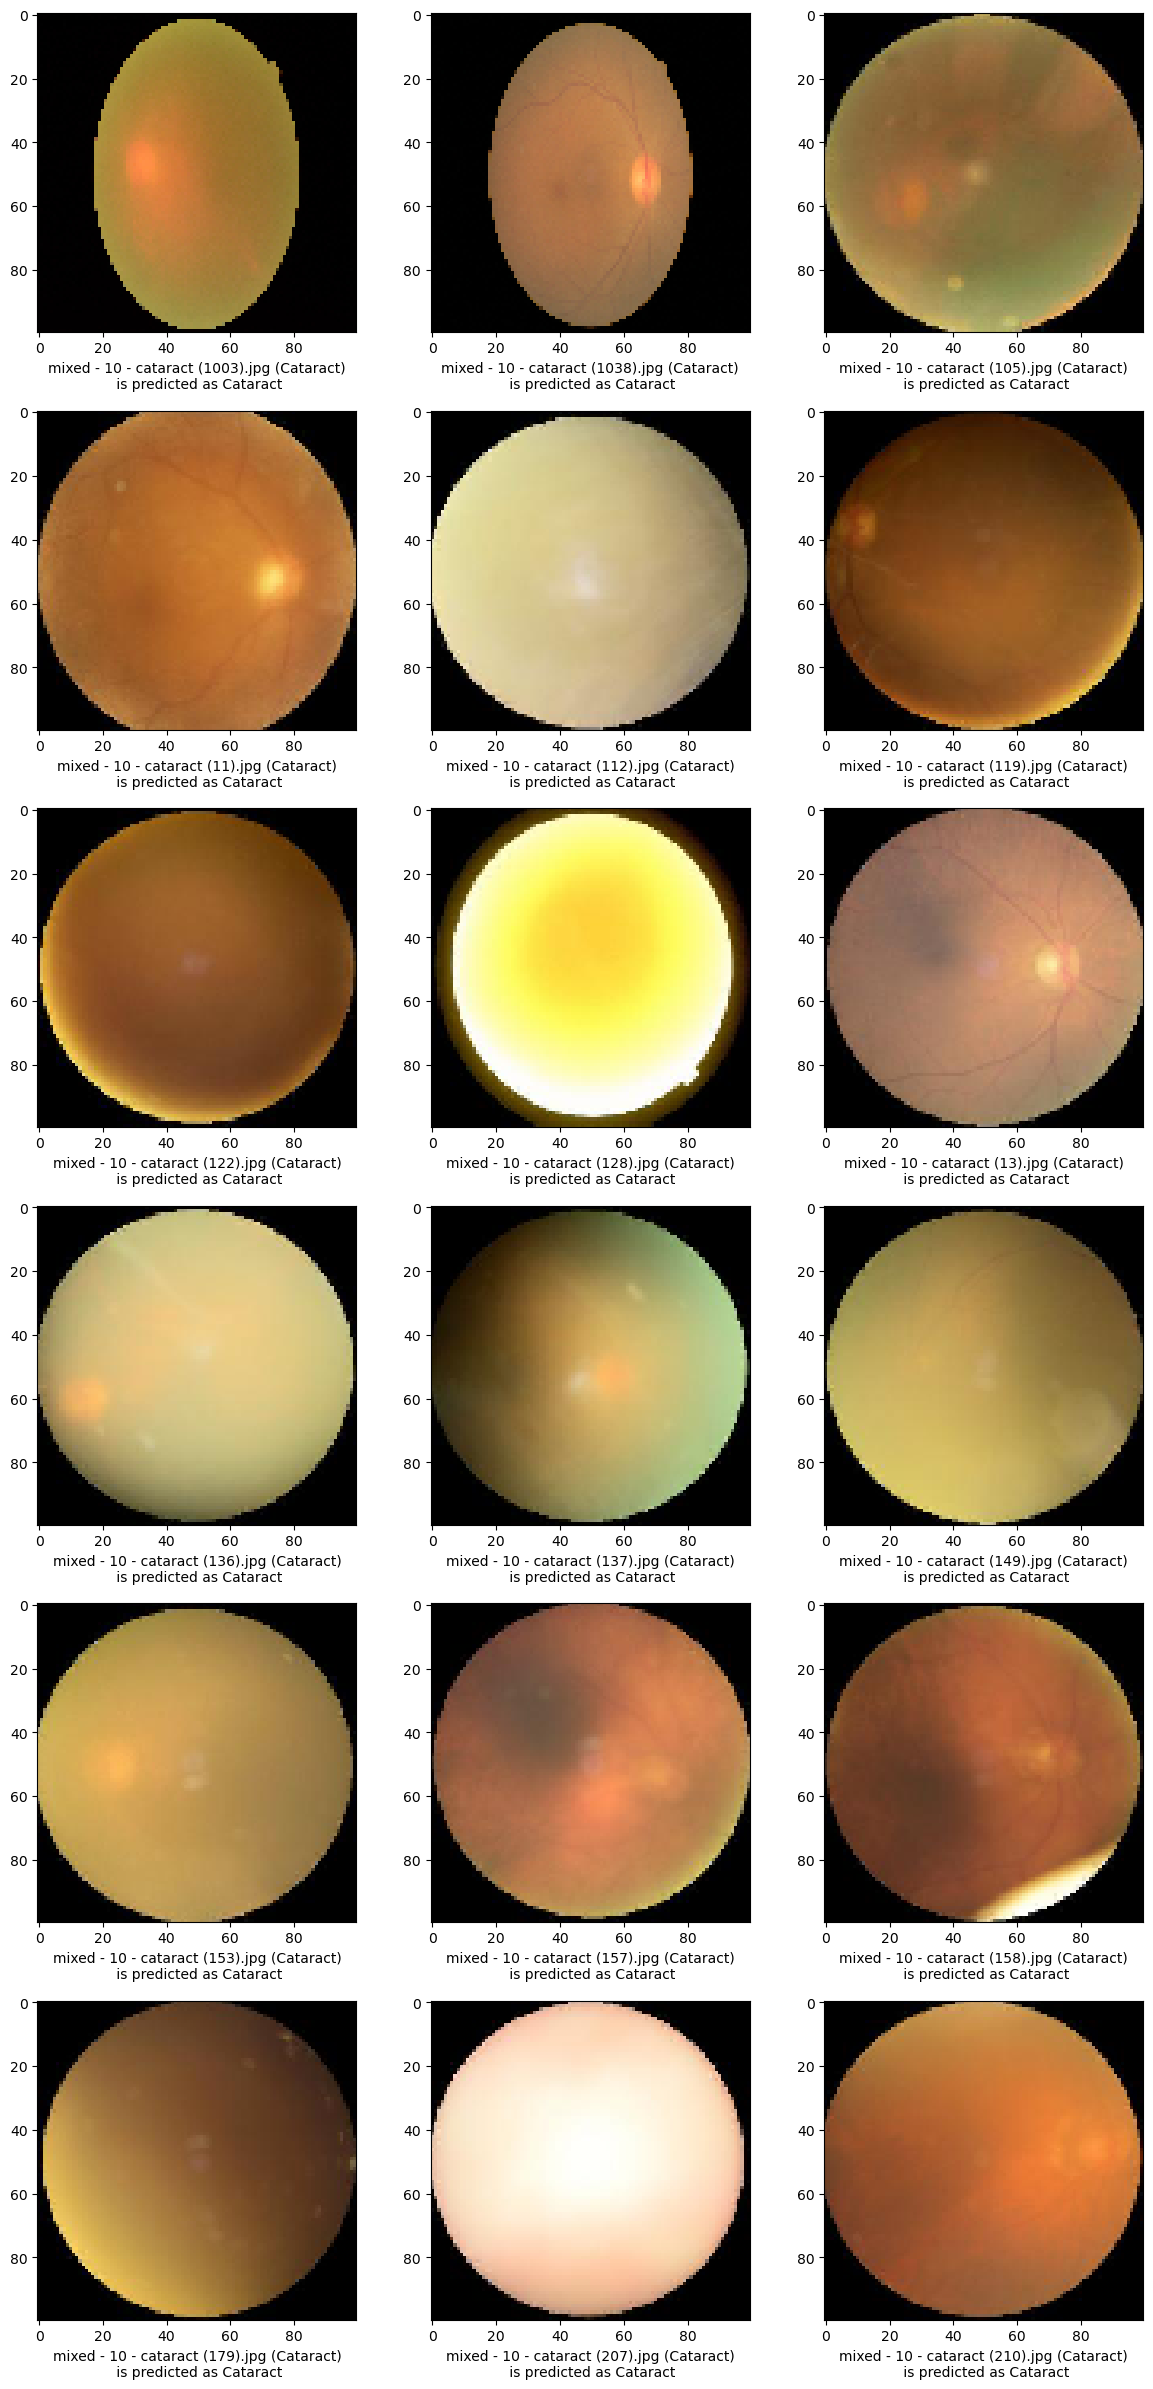

In [62]:
from tensorflow.keras.preprocessing.image import load_img

cataract_test_path = 'D:\\2110191048\\Dataset\\Dataset (Splitted)\\test\\Cataract\\'
dr_test_path = 'D:\\2110191048\\Dataset\\Dataset (Splitted)\\test\\DR\\'
glaucoma_test_path = 'D:\\2110191048\\Dataset\\Dataset (Splitted)\\test\\Glaucoma\\'
normal_test_path = 'D:\\2110191048\\Dataset\\Dataset (Splitted)\\test\\Normal\\'

sample_test = test_mixed_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img(cataract_test_path + filename, target_size=IMG_SIZE)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

## Evaluation metrics

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_in_numpy, y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true_in_numpy, y_pred_in_numpy, target_names=class_names))


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.95
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95


Classification Report

              precision    recall  f1-score   support

    Cataract       0.97      0.93      0.95       105
          DR       0.98      0.96      0.97       111
    Glaucoma       0.95      0.94      0.94       111
      Normal       0.90      0.96      0.93       108

    accuracy                           0.95       435
   macro avg       0.95      0.95      0.95       435
weighted avg       0.95      0.95      0.95       435



[[ 98   0   2   5]
 [  0 107   2   2]
 [  2   1 104   4]
 [  1   1   2 104]]


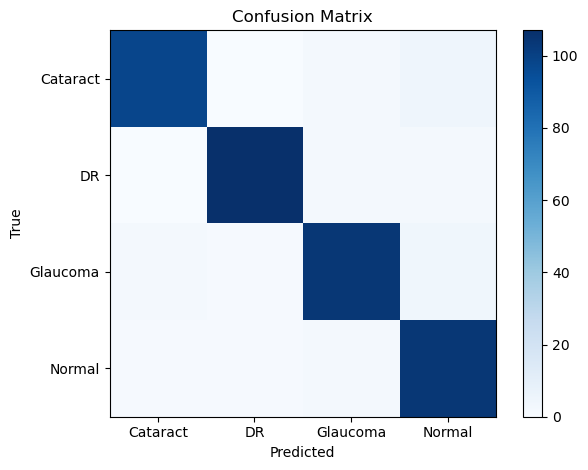

In [64]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_in_numpy, y_pred_in_numpy)
print(cm)

# Create labels for the matrix
labels = list(data_sets['test'].class_indices.keys())

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=0)
plt.yticks(tick_marks, labels)

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.tight_layout()
plt.show()

## Save the model

In [65]:
# model.save('')

## Use trained model for prediction

In [66]:
from tensorflow.keras.models import load_model, model_from_json, save_model

saved_model = load_model('D:\\2110191048\\eye-disease-classification-app\\deep-learning-model\\trained_model\\xception_mixed_best_model.h5', compile=True)

In [67]:
new_prediction_result = saved_model.predict(data_sets['test'])
print('Number of new predicted images:', len(new_prediction_result))
print('New prediction result:', new_prediction_result)
print('New prediction result shape:', new_prediction_result.shape)

new_predictions_df = pd.DataFrame(new_prediction_result)

14/14 [==============================] - 10s 695ms/step
Number of new predicted images: 435
New prediction result: [[9.9552554e-01 1.3024716e-03 2.8612788e-03 3.1069689e-04]
 [6.4808482e-01 4.4001866e-02 3.0604175e-01 1.8715337e-03]
 [9.8023707e-01 3.1430151e-03 7.2612674e-03 9.3586845e-03]
 ...
 [4.2512406e-06 5.6704199e-01 6.9771294e-04 4.3225604e-01]
 [2.1222459e-05 2.7835456e-01 6.9438369e-04 7.2092980e-01]
 [2.8876187e-03 1.7304799e-03 9.9634381e-05 9.9528223e-01]]
New prediction result shape: (435, 4)


In [68]:
new_predicted_id = tf.math.argmax(new_prediction_result, axis=1)
print('new_predicted_id len:', len(new_predicted_id))
print('new_predicted_id shape:', new_predicted_id.shape)
print('new_predicted_id:', new_predicted_id)
# class_names = np.array(class_names)
# predicted_label_batch = class_names[predicted_id]

# # print('Predictions:\n', predictions.numpy())
# print('Predictions:\n', predicted_label_batch)
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   # plt.title(class_names[predictions[i]])
#   plt.title(predicted_label_batch[i])
#   plt.axis("off")

new_predicted_id len: 435
new_predicted_id shape: (435,)
new_predicted_id: tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 1 0 0 0 0 3 3 0 0 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 1 1 1 1 1 3
 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 1 3 1 1 1 1 3 3 3 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 3 3 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 2 3 2 1 2 2
 2 2 3 3 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 3 0 3 3 3 1 3 3 3 3 3 1 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3], shape=(435,), dtype=int64)


In [69]:
new_y_pred_in_numpy = np.array(new_predicted_id)
new_y_pred_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3,
       3, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1,
       1, 1, 1, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1,
       2, 2, 2, 2, 3, 3, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [70]:
new_y_true_in_numpy = np.array(data_sets['test'].classes)
new_y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [71]:
new_predictions_df

,0,1,2,3
0,0.995526,0.001302,0.002861,0.000311
1,0.648085,0.044002,0.306042,0.001872
2,0.980237,0.003143,0.007261,0.009359
3,0.983681,0.000057,0.000756,0.015506
4,0.972257,0.000029,0.000215,0.027499
...,...,...,...,...
430,0.001460,0.126173,0.052015,0.820353
431,0.009639,0.250393,0.000128,0.739839
432,0.000004,0.567042,0.000698,0.432256
433,0.000021,0.278355,0.000694,0.720930


In [72]:
# Converts each predicted value into labels

new_predictions_df['y_pred'] = new_y_pred_in_numpy
new_predictions_df

,0,1,2,3,y_pred
0,0.995526,0.001302,0.002861,0.000311,0
1,0.648085,0.044002,0.306042,0.001872,0
2,0.980237,0.003143,0.007261,0.009359,0
3,0.983681,0.000057,0.000756,0.015506,0
4,0.972257,0.000029,0.000215,0.027499,0
...,...,...,...,...,...
430,0.001460,0.126173,0.052015,0.820353,3
431,0.009639,0.250393,0.000128,0.739839,3
432,0.000004,0.567042,0.000698,0.432256,1
433,0.000021,0.278355,0.000694,0.720930,3


In [73]:
# Add y_true into new_predictions_df

# print(data_sets['test'].classes)
new_predictions_df['y_true'] = new_y_true_in_numpy
new_predictions_df

,0,1,2,3,y_pred,y_true
0,0.995526,0.001302,0.002861,0.000311,0,0
1,0.648085,0.044002,0.306042,0.001872,0,0
2,0.980237,0.003143,0.007261,0.009359,0,0
3,0.983681,0.000057,0.000756,0.015506,0,0
4,0.972257,0.000029,0.000215,0.027499,0,0
...,...,...,...,...,...,...
430,0.001460,0.126173,0.052015,0.820353,3,3
431,0.009639,0.250393,0.000128,0.739839,3,3
432,0.000004,0.567042,0.000698,0.432256,1,3
433,0.000021,0.278355,0.000694,0.720930,3,3


In [74]:
new_predictions_df.columns = [class_names[0], class_names[1], class_names[2], class_names[3], 'y_pred', 'y_true']
new_predictions_df

,Cataract,DR,Glaucoma,Normal,y_pred,y_true
0,0.995526,0.001302,0.002861,0.000311,0,0
1,0.648085,0.044002,0.306042,0.001872,0,0
2,0.980237,0.003143,0.007261,0.009359,0,0
3,0.983681,0.000057,0.000756,0.015506,0,0
4,0.972257,0.000029,0.000215,0.027499,0,0
...,...,...,...,...,...,...
430,0.001460,0.126173,0.052015,0.820353,3,3
431,0.009639,0.250393,0.000128,0.739839,3,3
432,0.000004,0.567042,0.000698,0.432256,1,3
433,0.000021,0.278355,0.000694,0.720930,3,3


In [75]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\2110191048\\Dataset\\new_test_dataset_mixed.csv'
headers = ['Image', 'Label']

In [76]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [77]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\2110191048\\Dataset\\Dataset (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [78]:
# Load and preview the CSV dataset file

new_test_mixed_df = pd.read_csv('D:\\2110191048\\Dataset\\new_test_dataset_mixed.csv')
new_test_mixed_df

,Image,Label
0,mixed - 10 - cataract (1003).jpg,Cataract
1,mixed - 10 - cataract (1038).jpg,Cataract
2,mixed - 10 - cataract (105).jpg,Cataract
3,mixed - 10 - cataract (11).jpg,Cataract
4,mixed - 10 - cataract (112).jpg,Cataract
...,...,...
430,mixed - 10 - normal (966).jpg,Normal
431,mixed - 10 - normal (968).jpg,Normal
432,mixed - 10 - normal (969).jpg,Normal
433,mixed - 10 - normal (980).jpg,Normal


Label
DR          111
Glaucoma    111
Normal      108
Cataract    105
Name: count, dtype: int64

Total predicted images: 435


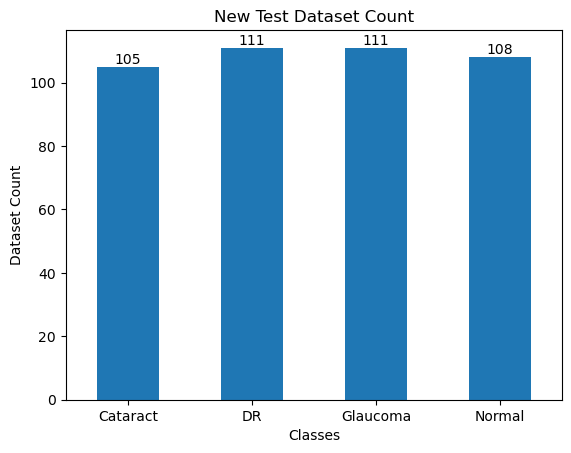

In [79]:
new_test_mixed_df['Label'].value_counts()
print(new_test_mixed_df['Label'].value_counts())

# View the above in a bar graph
new_test_df_chart = new_test_mixed_df.groupby('Label')['Image'].nunique().plot(
    kind='bar',
    title='New Test Dataset Count',
    xlabel='Classes',
    ylabel='Dataset Count',
    rot=0
)

new_test_df_chart.bar_label(new_test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", new_test_mixed_df.shape[0])

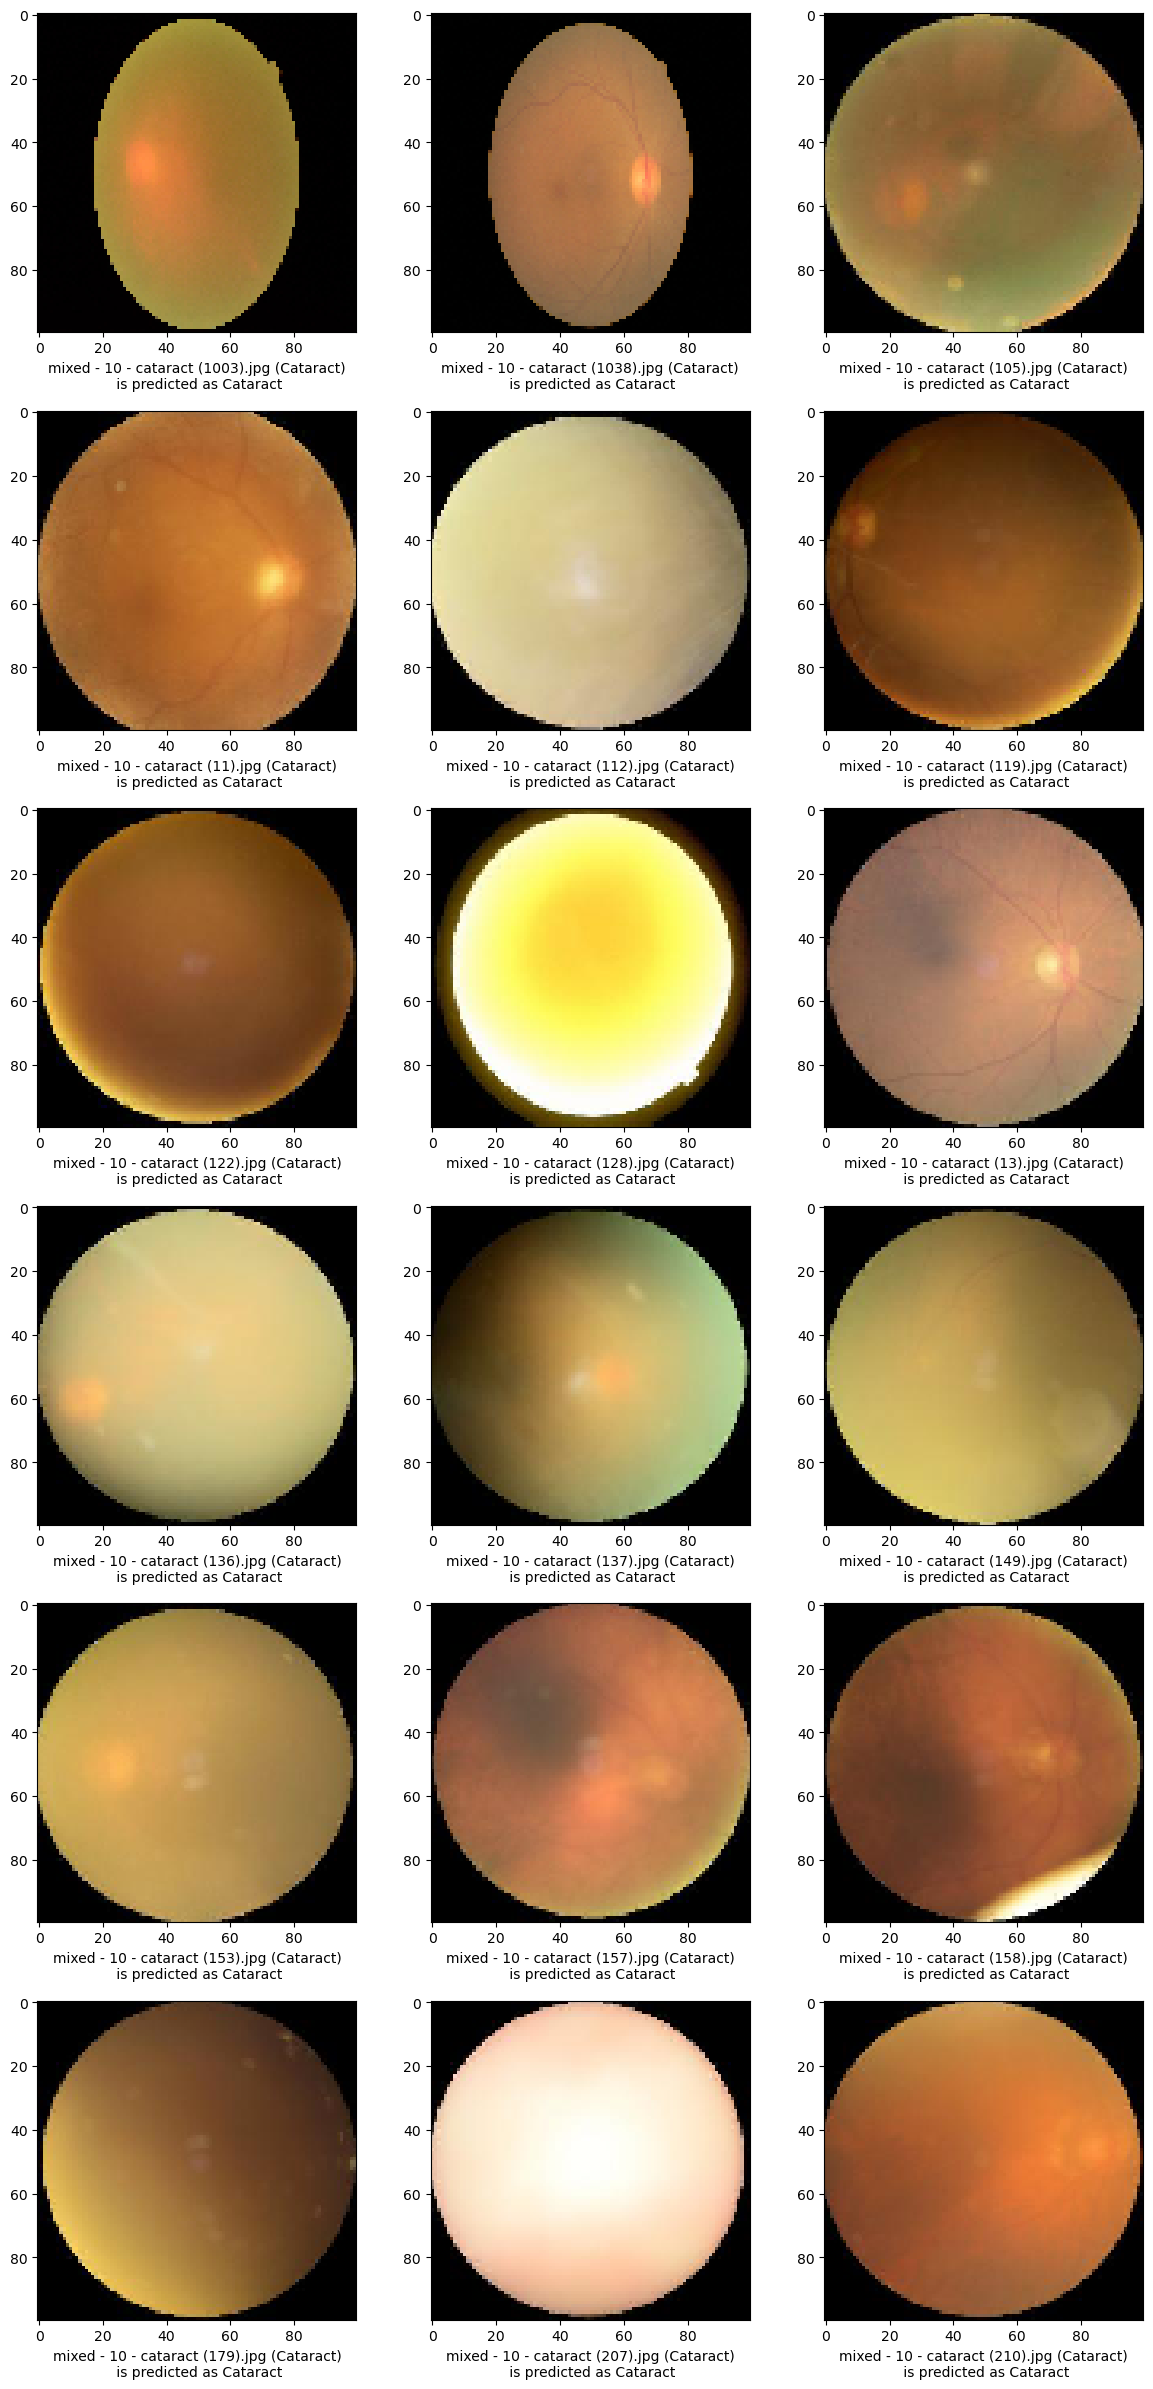

In [80]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = new_test_mixed_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\2110191048\\Dataset\\Dataset (Splitted)\\test\\Cataract\\' + filename, target_size=IMG_SIZE)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

In [81]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(new_y_true_in_numpy, new_y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(new_y_true_in_numpy, new_y_pred_in_numpy, target_names=class_names))


Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.90
Macro Recall: 0.89
Macro F1-score: 0.89

Weighted Precision: 0.90
Weighted Recall: 0.89
Weighted F1-score: 0.89


Classification Report

              precision    recall  f1-score   support

    Cataract       0.91      0.91      0.91       105
          DR       0.92      0.88      0.90       111
    Glaucoma       0.95      0.87      0.91       111
      Normal       0.82      0.91      0.86       108

    accuracy                           0.89       435
   macro avg       0.90      0.89      0.89       435
weighted avg       0.90      0.89      0.89       435



In [82]:
# Let's try, if the model can predict just one image

from tensorflow.keras.preprocessing import image

def predict_one_image(img_path, model=model):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, axis=0)
    
    print('img_array shape:', img_array.shape) 
    print('img_array type:', type(img_array))
    
    prediction_result = model.predict(img_array)
    
    print('Prediction_result:', prediction_result)    
    print('Prediction_result shape:', prediction_result.shape)    
    print('Prediction_result type:', type(prediction_result))   

    print('prediction_result[0]:', prediction_result[0])
    
    score = tf.nn.softmax(prediction_result[0])
    print('score:', score) 
    
    predicted_class = tf.argmax(prediction_result[0])
    print('Prediction_class:', class_names[predicted_class.numpy()])

In [83]:
mixed_normal_test_image = test_image_source = 'D:\\2110191048\\eye-disease-classification-app\\deep-learning-model\\mixed_test_images\\Diabetic Retinopathy.jpg'
predict_one_image(mixed_normal_test_image, saved_model)

img_array shape: (1, 100, 100, 3)
img_array type: <class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 2s 2s/step
Prediction_result: [[2.7775770e-05 9.2339620e-02 1.5221877e-02 8.9241070e-01]]
Prediction_result shape: (1, 4)
Prediction_result type: <class 'numpy.ndarray'>
prediction_result[0]: [2.7775770e-05 9.2339620e-02 1.5221877e-02 8.9241070e-01]
score: tf.Tensor([0.18008427 0.19749963 0.18284138 0.43957475], shape=(4,), dtype=float32)
Prediction_class: Normal
